#Homework 6: Clustering (K-means, DP-means)
by Junyu Liu and Brian Kulis

**Due date**: March 24, Wednesday by 11:59pm

**Late** due date: March 27, Saturday by 11:59pm

This homework has a total of 100 points, with a 10-point bonus question at the end. **Online code along with library functions for K-means or DP-means are prohibited.**

For all the functions you need to implement, feel free to change their signatures (inputs and returns) but do NOT change their names.

##**Question 1:**  K-means (35 points)

Here you will apply K-means on simple Gaussian data. You are given some code to assist you in implementing this clustering method.

###**a.** Create a dataset and plot it (10 points)
Generate $3$ $2$D Gaussian clusters of data with the following means and covariances:

$\boldsymbol{\mu}_0 = [2,2]^T, \boldsymbol{\mu}_1 = [-2,2]^T, \boldsymbol{\mu}_2 = [0,-2]^T$,

$\Sigma_0 = [[0.02,0];[0,0.02]]$, $\Sigma_1 = [[0.2,0];[0,0.2]]$, $\Sigma_2 = [[0.05,0];[0,0.05]]$ 

Let each cluster of data have $50$ points. Complete the scatter_by_category function and use it create a colored scatter plot of the generated Gaussian data.

**Important:** Assume **row** vectors for feature vectors and **column** vectors for mean vectors for the **entire** homework 6. This is a convention that makes matrix multiplications and dot products easier.

Hints: 
1. Use rng.multivariate_normal() to generate the dataset.
2. Use the imported seaborn library for plotting. Relevant documentation: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numexpr as ne
from scipy import sparse
from numba import njit
import time

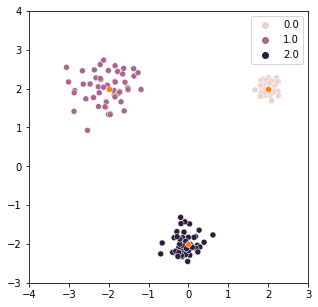

In [ ]:
# Do NOT change the seed in any problem, unless you are explicitly allowed to
# Use rng instances instead of using np.random directly, as recommended 
# by numpy manuals
rng = np.random.default_rng(0)

# Generate 2D Gaussian Data with 3 clusters of 3 different means
# WRITE CODE HERE:
mean_0 = np.array([2, 2])
mean_0 = mean_0.T
mean_1 = np.array([-2, 2])
mean_1 = mean_1.T
mean_2 = np.array([0, -2])
mean_2 = mean_2.T

MEAN = np.vstack((mean_0, mean_1))
MEAN = np.vstack((MEAN, mean_2))
MEAN = MEAN.T

LABEL = np.ones(150)
LABEL[0:50] *= 0
LABEL[50:100] *= 1
LABEL[100:150] *= 2

covariance_0 = np.matrix([[0.02, 0], [0, 0.02]])
covariance_1 = np.matrix([[0.2, 0], [0, 0.2]])
covariance_2 = np.matrix([[0.05, 0], [0, 0.05]])

DATA_0 = rng.multivariate_normal(mean_0, covariance_0, 50)
DATA_1 = rng.multivariate_normal(mean_1, covariance_1, 50)
DATA_2 = rng.multivariate_normal(mean_2, covariance_2, 50)

DATA = np.append(DATA_0, DATA_1, axis=0)
DATA = np.append(DATA, DATA_2, axis=0)

# m is an optional argument for cluster means; when supplied, the function
# should plot them in red
# As mentioned, the means are column vectors, so m has shape (d, k), 
# where d is the number of features
def scatter_by_category(X, labels, m=None):
    plt.figure(figsize=(5,5))
    plt.xlim([-4, 3])
    plt.ylim([-3, 4])
    # WRITE CODE HERE:
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels)
    sns.scatterplot(x=m[0,:], y=m[1,:])

scatter_by_category(DATA, LABEL, MEAN)

###**b.** K-means objective (5 points)
Implement the K-means objective (within-cluster sum of squares) function: $\sum\limits_{i=1}^k Var(C_i) = \sum\limits_{i=1}^k \sum\limits_{\mathbf x \in C_i} ||\mathbf x-\mathbf{\mu_i}||_2^2$

Note: we recommend that you either use njit or not use loops here. More note on njit can be found in question 3.b where a loop over the data is inevitable.

In [ ]:
@njit(fastmath=True,cache=True)
def WCSS(X, labels, m):
    # WRITE CODE HERE:
     numClusters = m.shape[1]
     objective = 0

     for i in range(numClusters):
       objective += (np.linalg.norm(X[labels == i] - m[:,i])**2)

     return objective

WCSS(DATA, LABEL, MEAN)

26.500636603591364

###**c.** Implement K-means (20 points)
Implement K-means and apply it to the Gaussian data above. The code below contains comments of what needs to be coded up at a specific part of the code.  Please write your code below these comments where necessary. 

Plot the created clusters per iteration in different colors. For convergence of the algorithm (stopping criterion), check whether the objective value becomes stationary (change less than a suitable threshold). Finally, print the final objective value.

Notes: 
1. As always, try to use vectorized routines instead of loops whenever possible. This will be important in a later question.

The algorithm took 4 iterations to terminate.
WCSS: 25.97578491943206
[[ 1.83001754  1.84764474  0.09195337]
 [-1.28519172 -2.67641579 -0.69978672]]


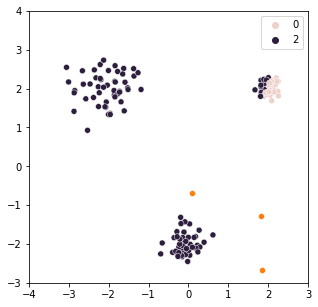

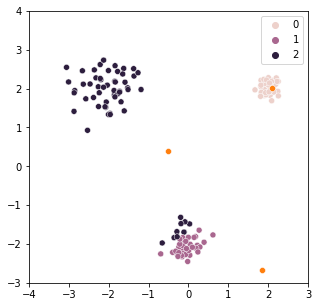

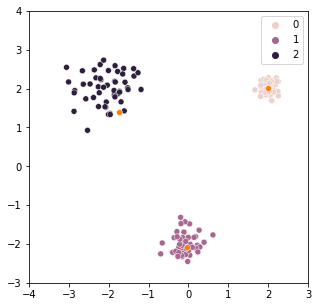

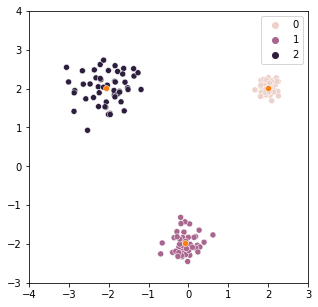

In [ ]:
## K-means implementation:
# X is the points as row vectors, m is the initial centers as column vectors
# maxT helps it terminate in case something goes wrong
# Feel free to change the function signatures
def k_means(X, m, maxT=10, threshold=.001, plots=False):
      (d, k), n = m.shape, X.shape[0]
      obj = 0
    # WRITE CODE HERE:
      for t in range(maxT):
        distance = np.array([])
          # 1. Assignment step - Assign each sample to the nearest mean vector:
        for mean in range(m.shape[1]):
          nearestLabel = [np.linalg.norm(X - m[:,mean], axis=1)][0]
          # print(nearestLabel)
          distance = np.append(distance, nearestLabel, axis=0)
          # print(distance)
        distance = np.reshape(distance, (m.shape[1], X.shape[0]))
        labels = np.argmin(distance, axis=0)
        # print(labels)
        minimums = np.min(distance, axis=0)
        # print(minimums)
          # 2. Conditionally plot clustering results:
        if plots: scatter_by_category(X, labels, m)
          # 3. Mean updating - Update the cluster means
          # Note: be careful with empty clusters; you don't want division by 0
          # If there are empty clusters, simply don't update their centers
        newMean = np.array([])
        for label in range(k):
          if ((X[labels == label]).any()):
            newMean = np.append(newMean, np.mean(X[labels == label], axis=0))
          else:
            newMean = np.append(newMean, m[:,1], axis=0)
        m = np.transpose(np.reshape(newMean, (k,d)))
        # print(newMean)
        # print(m)
          # 4. Check for convergence
        prevObj = obj
        obj = WCSS(X, labels, m)
        # print(obj)
        if abs(prevObj - obj) <= threshold: break # CHANGE THIS
      return labels, obj, t+1, m
    
# Do NOT change the seed in any problem, unless you are explicitly allowed to
rng = np.random.default_rng(5)
num_clusters = 3
m = np.asfortranarray(rng.random((2, num_clusters)))
ne.evaluate('6*m - 3', out=m) # Magic formula ;)
labels, obj, iters, temp_m = k_means(DATA, m, plots=True)
print('The algorithm took', iters, 'iterations to terminate.')
print('WCSS:', obj)
print(m)

##**Question 2:** The MNIST Dataset (25 points)
Here comes your first decently-sized dataset this semester, the MNIST Dataset. The dataset contains 70000 28x28 preprocessed images of handwritten didits. Before proceeding further, you should familiarize yourself with the dataset, and we have provided a few cells to help you. You can modify them as long as you don't mess up the dataset.

Due to the large size of MNIST, the following cells might take a while to run, so be patient.

In [ ]:
# Fetching the MNIST dataset takes a while
# You only need to run this cell once per session
start = time.process_time()
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)
print(time.process_time()-start, 'seconds')

24.454016748999948 seconds


0.0 255.0


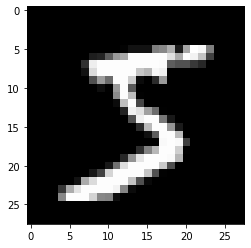

Fraction of X that is non-zero: 0.19142447157434403
(70000, 784)
439040000 bytes
Are row elements contiguous? False
float64


In [ ]:
print(min(X[0]), max(X[0]))
plt.imshow(X[0].reshape(28, 28), 'gray')
plt.show()

print('Fraction of X that is non-zero:', np.count_nonzero(X)/X.size)
print(X.shape)
print(X.nbytes, 'bytes')
print('Are row elements contiguous?', X.data.c_contiguous)
print(X.dtype)

###**a.** Preprocessing for speed (5 points)
Preprocessing is critical in ML for many reasons. One of them is that it can make the data more friendly to both your code and your hardware, potentially saving you tons of time. Based on the observations above, what things can you do to the MNIST data to speedup your algorithms without compromising the data? Explain why they are beneficial for speed for full credit.

Notes: 
1. Although recommended, you do not have to apply all of your answers here in code.
2. Assume your code will be run on typical modern CPU.

In [ ]:
X = X.astype(np.float32)
X = X/256

###**b.** K-means on MNIST (10 points)
Now peform K-means on MNIST. We have provided the initializations for you, in the variable m2. This dataset will stress test your K-means implementation, so it's important that you use optimized routines. You can lower maxT if it takes too long, but no lower than 15. If your algorithm can't terminate in 60 seconds in our testing, there will be some penalty. If you really have trouble getting it to terminate in a reasonable amount of time, take a subset of X by performing something like Xs = X[:10000], but there will be some penalty.

Hints:
1. Avoid loops that iterate over the dataset. If you really hav issue vectorizing, try to use the nopython JIT compiler (njit) from Numba to speed up your loops. See Question 3 code comments for more details on njit. This is not recommeneded however, as writing a jitted function usually requires more work than simply finding vectorized equivalents. You are also unlikely to match the speed of Numpy's vectorized routines this way.
2. $||\mathbf a - \mathbf b||_2^2 = \mathbf{a \cdot a} + \mathbf{b \cdot b} - 2\mathbf{a \cdot b}$
3. $\underset{\mathbf b \in \mathbf B}{\arg\min} ||\mathbf a - \mathbf b||_2^2 = \underset{\mathbf b \in \mathbf B}{\arg\min}~\mathbf{b \cdot b} - 2\mathbf{a \cdot b}$

In [ ]:
# Definitely do NOT try naive printing/plotting this dataset
# Do NOT set plots=True when calling k_means
rng = np.random.default_rng(70)
# USE THESE parameters; note the names are different from those
# in question 1 to prevent accidental plotting
m2 = np.asfortranarray(rng.random((784, 10), np.float32))
m2/= 4
maxT = 15
threshold = 16
start = time.process_time()
# Run K-means on MNIST HERE:
labels, obj, iters, mean_result = k_means(X, m2, maxT, threshold, plots=False)
print(time.process_time()-start, 'seconds')
print('The algorithm took', iters, 'iterations to terminate.')
print('WCSS:', obj)

50.59502736799993 seconds
The algorithm took 15 iterations to terminate.
WCSS: 2740834.699830658


###**c.** Show the final centers as images (5 points)
Hint: use subplots


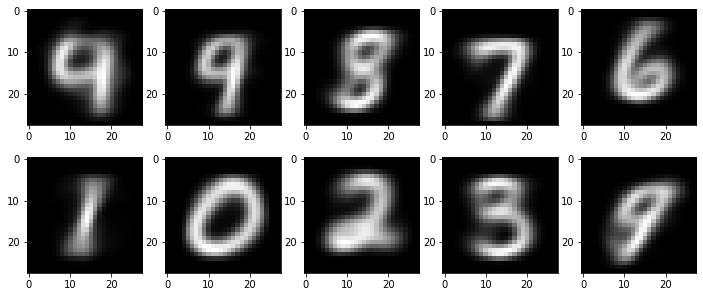

In [ ]:
# WRITE CODE HERE:
figsize=(12, 5)
fig = plt.figure(figsize=figsize)
for mean in range(mean_result.shape[1]):
  fig.add_subplot(2, 5, mean+1)
  plt.imshow(mean_result[:,mean].reshape(28, 28), 'gray')
plt.show()

###**d.** Avoiding bad initializations (5 points)
A simple way to mitigate the risk of bad initializations is to use multiple random ones to obain multiple solutions, compare them, and keep the best one according to an objective function. Run K-means on MNIST 3 more times, each with a different initialization, and keep only the current best solution. Finally, show the best solution's centers as images and report WCSS.

Note:
1. there is no time limit for this part, but you need to run your code to generate your own images. The run time shown in the preview is just for reference.
2. Use initializations methods analogous to the one in part b if you want to get the same results as shown.

In [162]:
start = time.process_time()
for i in range(3):
    m_tmp = np.asfortranarray(rng.random((784, 10), np.float32))
    m_tmp/= 4
    labels_tmp, obj_tmp, iters, m_tmp = k_means(X, m_tmp, 30, 16)
    if obj_tmp < obj: obj, m2 = obj_tmp, m_tmp

print(time.process_time()-start, 'seconds')
print('WCSS:', obj) # The lowest WCSS from the four solutions

296.8757706399999 seconds
WCSS: 2722938.324806606


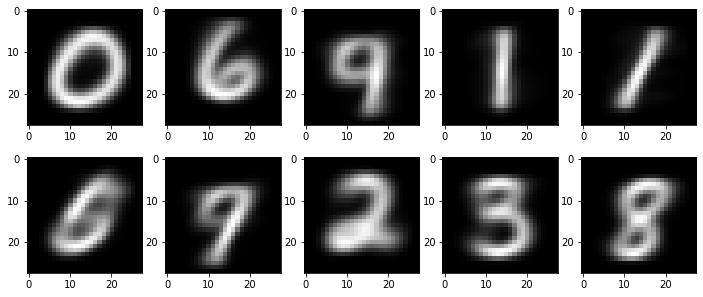

In [163]:
# WRITE CODE HERE:
figsize=(12, 5)
fig = plt.figure(figsize=figsize)
for mean in range(m2.shape[1]):
  fig.add_subplot(2, 5, mean+1)
  plt.imshow(m2[:,mean].reshape(28, 28), 'gray')
plt.show()

##**Question 3:** DP-means (40 points)

Here, you will implement DP-means and test it out on the dataset from question 1.



###**a.** The role of $\lambda$ (5 points)
Describe what the $\lambda$ parameter does in the DP-means algorithm discussed in class. 

The lambda parameter specifies the minimum distance between cluster means, meant to ensure clusters don't overlap.

###**b.** Implement DP-means (25 points)
Implement DP-means and apply it to the 2D Gaussian data from question 1. The code below contains comments of what needs to be coded up at a specific part of the code.  Please write your code below these comments where necessary. 

Plot the created clusters per iteration in different colors. Similar to K-means, check how much the objecive value changed to determine convergence. The DP-means objective is given by $\lambda k+ \sum\limits_{i=1}^k Var(C_i)$

Use $\lambda$ = 4 and plots=True so your function produce plots over the iterations.

In [ ]:
def DP_means_obj(X, m, Lambda, labels):
    # WRITE CODE HERE:
    numClusters = m.shape[1]
    objective = 0

    for i in range(numClusters):
      objective += (np.linalg.norm(X[labels == i] - m[:,i])**2)

    objective += Lambda * numClusters

    return objective

## DP-means sub-routine:
# Remove @njit if you have issues with it and don't want to do the bonus 
# question. Numba can speedup for loops and Numpy sigificantly, but it often 
# has issues with python lists, scipy, pyplot, etc. It should be able to handle
# everything you need to do in onepass. Numba really prefers row vectors, 
# so passing in m.T instead of m is highly recommended. As always, you are
# welcome to change te function signature as long as you make it work.
# @njit(fastmath=True, cache=True)
def onepass(X, mT, Lambda): # welcome to change the signature
    (k, d), n = mT.shape, X.shape[0]
    labels = np.array([])
    # WRITE CODE HERE:
    # Iterating over X is required by the DP-means algorithm
    for i in range(n):
        # 1. Calculate distance from current point to all centers
        distances = np.array([])
        k = mT.shape[0]
        for center in range(k):
          distance = [np.linalg.norm(X[i,:] - mT[center,:])]
          distances = np.append(distances, distance, axis=0)
        # 2. Check how far the clostest center is; add the currect point as
        # a center if necessary (add it to mT)
        nearest = np.min(distances)
        nearestIndex = np.argmin(distances)
        if nearest > Lambda: # CHANGE THIS
            mT = np.append(mT, np.reshape(X[i,:], (1,2)), axis=0)
            labelIndex = mT.shape[0]+1
            labels = np.append(labels, labelIndex)
            pass
        else:
            # assign point to the closest center
            labels = np.append(labels, nearestIndex)
            pass
    # m should be returned because the updates performed may not be in place
    return mT.T, labels # reversing the transpose

In [ ]:
## DP-means main function:
def DP_means(X, m, Lambda=2, maxT=10, threshold=.001, plots=False):
    (d, k), n = m.shape, X.shape[0]
    obj = 0
    # WRITE CODE HERE:
    for t in range(maxT):
        # 1. Implement the onepass function and use it here
        mT, labels = onepass(X, m.T, Lambda)
        # print(labels)
        # 2. Conditionally plot clustering results:
        if plots: scatter_by_category(X, labels, m)
        # 3. Mean updating - Update the cluster means
        # Similar to K-means, be careful about empty clusters
        newMean = np.array([])
        for label in range(k):
          if ((X[labels == label]).any()):
            newMean = np.append(newMean, np.mean(X[labels == label], axis=0))
          else:
            newMean = np.append(newMean, m[:,0], axis=0)
        m = np.transpose(np.reshape(newMean, (k,d)))
        prevObj = obj
        obj = DP_means_obj(X, m, Lambda, labels)
        # print(obj)
        # 4. Check for convergence based on how much k and m changed
        if np.abs(prevObj - obj) <= threshold: break # CHANGE THIS
    return m, t+1

[[0.63696169]
 [0.26978671]]
Value of the objective: 2723980.5834883344


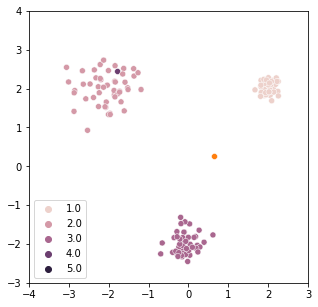

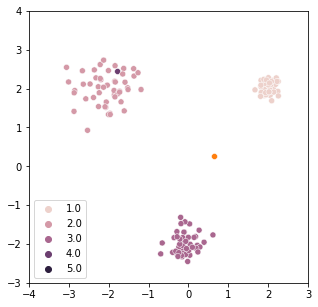

In [ ]:
rng = np.random.default_rng(0)
m = np.asfortranarray(rng.random((2, 1)))
# WRITE CODE HERE:
DP_means(DATA, m, Lambda=2, maxT=10, threshold=.001, plots=True)
print(m)
print('Value of the objective:', obj)

###**c.** Reflection (4 points)
If your implementation runs correctly, you should see the solution having one more center than the "expected" 3. **Explain why this happens and suggest a simple, generalizable fix for this.** (generlizable means you can apply this fix easily on other datasets). Also demonstrate this fix in code for full credit.

This is because the initial center is provided at random and is not close enough to any point. Choosing a random point from the dataset to serve as the initial center would solve this issue. (I agree).

(2, 2)
[[0.63696169]
 [0.26978671]]
The algorithm took 30 iterations to terminate.
Value of the objective: 2723980.5834883344


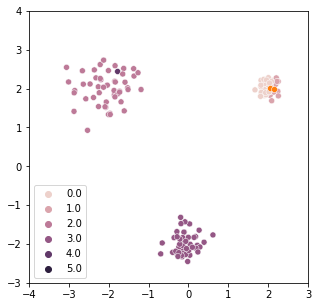

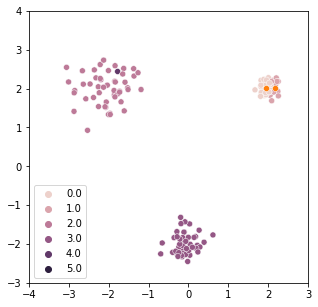

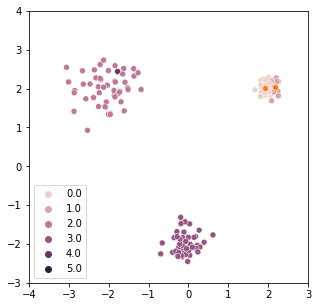

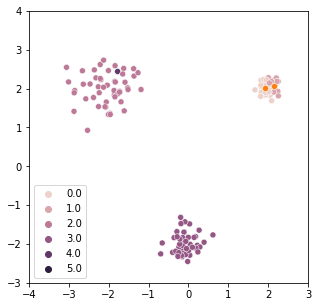

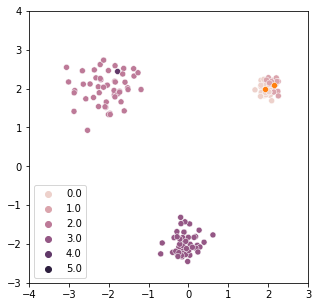

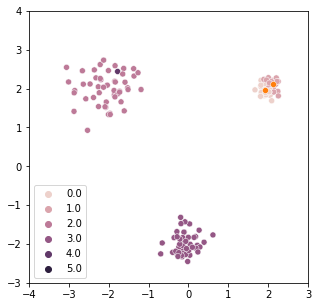

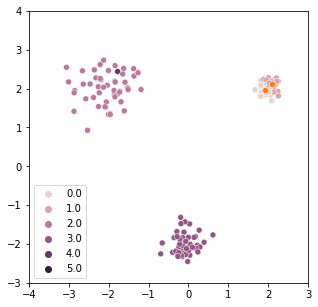

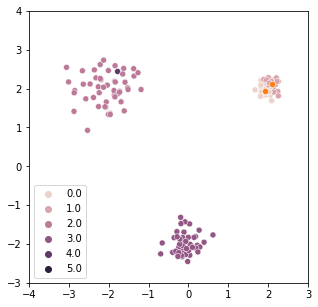

In [ ]:
# WRITE CODE HERE:
DATA_rand = np.array(DATA[np.random.randint(DATA.shape),:])
print(DATA_rand.shape)
DP_means(DATA, m=DATA_rand, Lambda=2, maxT=10, threshold=.001, plots=True)
print(m)
print('The algorithm took', iters, 'iterations to terminate.')
print('Value of the objective:', obj)

###**d.** Try different $\lambda$ values (6 points)
Run DP-means with the following $\lambda$ values:

$\underline{\lambda} = [1,9,16]$

For each $\lambda$ value, plot the resulting clusters and report the final objective value.

Note: The solution shown is obtained without the expected fix in part c.

Lambda = 1
The algorithm took 30 iterations to terminate.
Value of the objective: 2723980.5834883344


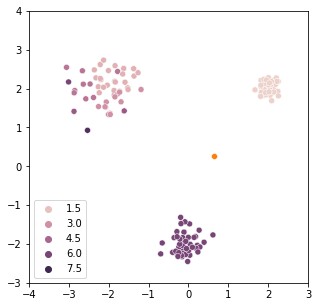

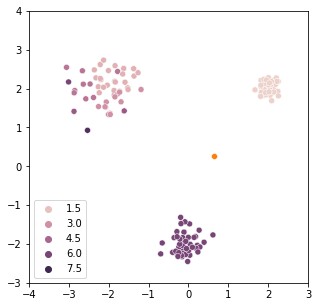

In [ ]:
rng = np.random.default_rng(50)
print('Lambda = 1')
# WRITE CODE HERE:
DP_means(DATA, m, Lambda=1, maxT=10, threshold=.001, plots=True)
print('The algorithm took', iters, 'iterations to terminate.')
print('Value of the objective:', obj)

Lambda = 9
[[0.63696169]
 [0.26978671]]
The algorithm took 30 iterations to terminate.
Value of the objective: 2723980.5834883344


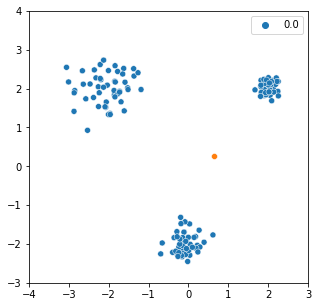

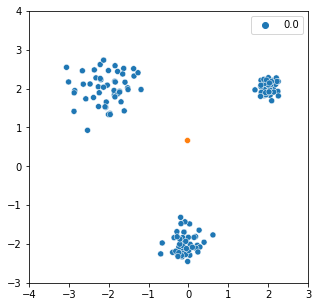

In [ ]:
print('Lambda = 9')
# WRITE CODE HERE:
DP_means(DATA, m, Lambda=9, maxT=10, threshold=.001, plots=True)
print(m)
print('The algorithm took', iters, 'iterations to terminate.')
print('Value of the objective:', obj)

Lambda = 16
[[0.63696169]
 [0.26978671]]
The algorithm took 30 iterations to terminate.
Value of the objective: 2723980.5834883344


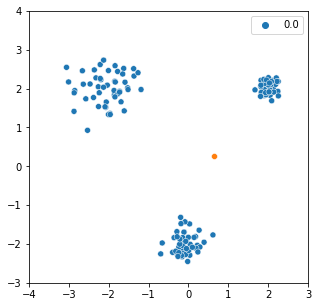

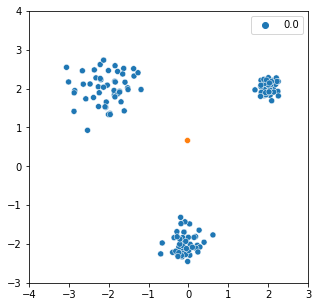

In [ ]:
print('Lambda = 16')
# WRITE CODE HERE:
DP_means(DATA, m, Lambda=16, maxT=10, threshold=.001, plots=True)
print(m)
print('The algorithm took', iters, 'iterations to terminate.')
print('Value of the objective:', obj)

##**Question 4:** DP-means on MNIST (Bonus 10 points)
This extra credit is fairly open-ended, just get **your** DP-means implementation to run reasonably well on MNIST.

You may run DP-means on a subset of MNIST, but the subset should contain at least 10000 samples.

Aim to achieve the following (ranked by importance):
1. Show the final centers as images. Your images need to look like those shown in the preview.
2. Find a suitable $\lambda$ and initial m that produce 10 to 30 clusters.
3. maxT must be at least 10. (Our solution uses 30)
4. The run time should be within 60 seconds.

Notes:
1. $\lambda$ needs to be relatively large. It's better to start high and then decrease to find an appropriate value.
2. All solution previews in this homework are generated from running on the entire dataset.

In [ ]:
# Initialize HERE:
DP_means(X, m2, Lambda=100, maxT=10, threshold=.001, plots=True)
start = time.process_time()
# Run DP-means on MNIST HERE:
print(time.process_time() - start, 'seconds')
print('Shape of the means matrix:', m2.shape)
print('The algorithm took', iters, 'iterations to terminate.')
print('Value of the objective:', obj)

ValueError: ignored

In [ ]:
# WRITE CODE HERE:
figsize=(10, 8)